#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
length_p=[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 227.30729728986748]

In [29]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [30]:
rng = np.random.default_rng()

In [31]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [32]:
sum_=0
length_sum=[]
for i in range(node_N-1):
    sum_+= length_p[i]
    length_sum.append(sum_)

In [33]:
def Re_t(a,b,c,l):
    xyz=np.stack((a,b,c), axis=1)
    Ret=np.apply_along_axis(Re_t_, 1, xyz)
    
    for i in range(node_N-1):    
         Ret[i]*=(l[-1]-l[i])
    Ret[-1]*=0.5*l[-1]        
   
    return Ret

In [34]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.37785492, -0.59716724,  0.7075429 ],
       [-0.13684956,  0.71978085,  0.68057897],
       [-0.91569529, -0.35398704,  0.19025066]])

In [35]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ,length_sum)
print(datetime.now() - startTime1)

0:00:00.011854


In [36]:
Ret.shape

(50, 3, 3)

In [37]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [38]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64))) 
    
    ans_x=[]
    ans_y=[]
    ans_z=[]

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(Ret[i],B.T[i].astype(np.float64), rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    x_,y_, z_ = np.array(ans_x),np.array(ans_y),np.array(ans_z) 
    
   
    
    return  np.stack([x_,y_, z_], axis=1).T

In [39]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.004833


In [40]:
C1(dx,dy,dz,Ret).shape

(3, 50)

In [41]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [42]:
fD(dx,dy,dz,DT,Ret).T

array([[-5.35797737e-01, -9.48410356e-01,  5.27108951e-01],
       [ 9.78200968e-02, -1.70355484e-01,  6.29498581e-01],
       [ 1.57035003e+00, -2.57312034e-01, -5.05870610e-01],
       [ 1.85319278e-01,  5.11882341e-01, -7.86608153e-02],
       [ 2.22324098e-01, -1.43814598e-01, -5.03476941e-02],
       [-5.15203341e-01,  5.15931793e-01, -3.86136005e-01],
       [ 1.03283338e+00,  1.06173603e+00,  2.50391982e+00],
       [ 6.06047813e-01, -1.31034106e-01, -3.85720286e-01],
       [ 3.49901509e+00, -3.42524172e-01,  3.59093614e+00],
       [ 1.63900099e+00,  1.38099664e+00, -8.14846604e-01],
       [-1.20935157e+00,  1.12632480e+00, -2.67133682e+00],
       [-1.16667363e+00,  6.66052245e-01, -4.58625074e+00],
       [ 3.34699602e+00, -1.27031020e+00,  5.47077620e-01],
       [-2.86289462e+00, -1.19809687e+00, -1.30291190e+00],
       [-5.33305116e-01, -6.86911395e-01, -3.64127447e+00],
       [-9.56394273e-01,  2.74114271e-01, -4.06463582e-01],
       [ 7.69410081e-02, -1.16406781e+00

In [43]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.008295


In [44]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [45]:
I=np.identity(3)

In [46]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.004275


In [47]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [48]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [49]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [50]:
DR=np.diag(diag_DR) 

In [51]:
Ar

0.08091250419136858

In [52]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [53]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [54]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [55]:
def Re_b(Ret):
    return Ret

In [56]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000136


In [57]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
#     return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))


    ans_x=[]
    ans_y=[]
    ans_z=[]

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(Ret[i].astype(np.float64),B.T[i].astype(np.float64), rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    x_,y_, z_ = np.array(ans_x),np.array(ans_y),np.array(ans_z) 
    
   
    
    return  np.stack([x_,y_, z_], axis=1)


#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [58]:
phi(x,y,z,Ret,None,None)

array([[-2.08601164e-06, -1.02944128e-04, -6.50513899e-05],
       [ 1.19327845e-04,  8.64760284e-05, -9.47371656e-05],
       [ 4.13222526e-05,  1.55517398e-05, -1.30982826e-04],
       [-7.06420561e-05,  2.41558668e-05,  7.42416661e-05],
       [ 8.16704547e-05,  1.46858278e-04, -7.78867399e-05],
       [-7.92448390e-05, -5.17747169e-05,  5.96348785e-05],
       [ 1.63263982e-04,  3.58148749e-05,  8.11497371e-05],
       [-6.99965789e-05, -7.79760768e-05, -1.27185528e-05],
       [ 1.87697732e-04, -1.86884964e-04, -1.31468825e-04],
       [-1.92746842e-04, -8.60425828e-05, -8.19232045e-05],
       [-2.03629690e-05, -1.40068738e-06, -4.19640046e-05],
       [ 1.35790293e-04, -7.72295273e-05, -1.10688351e-05],
       [ 1.24185438e-04,  7.62437487e-05, -4.84936005e-05],
       [ 1.84430674e-06, -8.07518113e-05,  6.44281893e-06],
       [ 6.26281588e-05,  3.66131690e-05, -4.66987105e-05],
       [-2.21014298e-04, -1.64699530e-04, -6.61834048e-05],
       [ 1.55110927e-04,  9.41681038e-05

In [59]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.016418


In [60]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [61]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [62]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001308


In [63]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [64]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.002755


In [65]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.72565638,  1.75549463,  1.11005587],
       [-0.61915757,  0.39028977, -0.12408834],
       [ 0.79057194,  1.07955543,  0.19339199],
       [-0.35953687,  0.1232503 ,  0.26478477],
       [-0.39121271,  2.04602371, -0.84704822],
       [ 0.33833662,  0.60614063,  0.29505663],
       [-0.18683246,  1.27755327,  1.36772042],
       [ 1.07527005, -0.82873277,  0.80742265],
       [-0.83258398, -0.15694606,  0.86928928],
       [-1.07798818, -0.47638761, -0.23722345],
       [-0.7776782 , -0.49202583, -0.47654384],
       [ 0.16771384,  1.63252846, -1.56844302],
       [-0.08913551,  0.04461261, -1.19817777],
       [ 0.222692  , -1.27952509,  0.94228762],
       [-0.71369751,  0.47236239, -0.58254526],
       [-1.62621038, -0.87886055,  1.2488186 ],
       [-0.25508377, -2.37545476, -1.33438254],
       [-0.10893277,  0.96164665,  0.65787408],
       [-0.149535  ,  0.75661927,  0.39646804],
       [ 0.26727613, -0.37588322, -0.05808084],
       [-1.16545873,  0.39906594,  0.046

In [66]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    
    fun = f(a,b,c,Ret,omega, force) 
    
    if flag==1:
        fun+=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [67]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [68]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[ 2.57561836e+00,  2.59022148e+00, -3.00951893e-01,
         2.38502672e+00,  1.03315292e+00,  8.87040999e-01,
         6.60172929e-02, -1.41813274e+00,  1.27105679e+00,
         1.98592535e+00,  1.88190965e+00,  4.41112075e-01,
         3.74000112e-01,  7.48770563e-01,  1.49674482e+00,
        -3.48076762e-01,  1.44207882e+00,  1.53173471e+00,
         1.54637177e+00,  6.21567098e-01,  1.39105735e+00,
         1.70660107e+00,  1.52743578e+00,  1.43136358e+00,
         9.57534306e-01, -7.89059343e-01,  9.08584653e-01,
        -5.14939922e-01,  9.27204530e-01, -1.84165713e-02,
         5.94075099e-01, -2.46250862e-01,  7.19162990e-01,
        -4.11037761e-01,  7.74018194e-01, -1.86656972e-01,
        -6.67123160e-02, -6.49551962e-01,  4.90707657e-01,
         4.11094084e-01,  4.38797828e-01,  2.44349075e-02,
         2.93525633e-01,  2.50699731e-01,  2.15343410e-01,
         1.94043836e-01,  1.20372165e-01,  3.23108614e-02,
         0.00000000e+00,  9.62133420e-01],
       [ 2.19

In [69]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.005906


In [70]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [71]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [72]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[ 1.55849750e-06, -1.19914903e-06,  4.51318405e-07,
        -6.65081805e-08, -6.31796394e-07,  1.24742020e-06,
        -1.70245442e-06, -6.80918082e-07, -3.08198771e-06,
         4.28970295e-07, -1.03233667e-07,  3.06291970e-07,
         7.83165123e-07,  6.50579440e-07, -2.17163819e-07,
         1.10969153e-06,  4.67476306e-07,  1.22675053e-06,
        -4.96565288e-06, -6.17912674e-09, -2.27983527e-07,
         8.68513969e-07, -2.96218684e-07,  1.52697852e-06,
        -1.19851746e-07,  2.81614574e-06, -5.44821873e-07,
        -2.11064137e-07, -3.23364023e-06,  8.77994467e-07,
        -1.11816818e-06, -7.78841213e-08,  4.68876797e-07,
        -3.50247930e-06,  1.66042776e-06, -1.92321004e-06,
        -1.10809063e-06,  7.92037938e-07,  5.31684414e-07,
        -6.09241133e-07,  3.87718031e-07, -3.40138573e-06,
         2.22705972e-06,  2.48314376e-06,  8.97398109e-07,
         1.42642310e-06, -8.44047349e-07,  5.87563957e-07,
        -2.71149179e-07, -3.47312635e-09],
       [-4.53

In [73]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [74]:
ne_(dx,dy,dz,DT,Ret)

array([[ 5.35797737e-01, -9.78200968e-02, -1.57035003e+00,
        -1.85319278e-01, -2.22324098e-01,  5.15203341e-01,
        -1.03283338e+00, -6.06047813e-01, -3.49901509e+00,
        -1.63900099e+00,  1.20935157e+00,  1.16667363e+00,
        -3.34699602e+00,  2.86289462e+00,  5.33305116e-01,
         9.56394273e-01, -7.69410081e-02,  2.39448021e+00,
         9.47046848e-01,  4.29619827e-01,  5.76613054e-01,
        -2.45632316e+00,  1.06369519e+00,  4.87134826e-01,
        -9.51457621e+00,  1.39209107e+00,  2.54394196e-01,
         1.12202876e-02, -9.33361138e-01,  4.29754974e+00,
        -4.36712508e+00,  4.60308114e-01, -3.67359837e+00,
        -3.76422485e+00,  3.13317089e-01,  2.06810906e-01,
         6.31425394e-01, -1.37233914e+00,  7.39047460e+00,
         2.82729128e-01, -4.54345046e-01, -9.78215440e-01,
        -3.25567695e+00,  1.10758545e+01,  2.47289708e+00,
        -4.02827526e+00,  3.55465104e+01, -3.13752859e+00,
        -0.00000000e+00,  7.30095294e-01],
       [ 9.48

In [75]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.008175


In [76]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[-4.83066621e+13, -1.11430632e+14,  1.59737390e+14],
       [-1.92619460e+14, -6.16543928e+14,  8.09163773e+14],
       [ 4.12910865e+14, -1.08323576e+14, -3.04588115e+14],
       [ 3.18702807e+14, -1.05019692e+15,  7.31493473e+14],
       [ 3.56379596e+14, -5.03376189e+12, -3.51346547e+14],
       [ 6.28991100e+14, -6.38534578e+14,  9.54222047e+12],
       [ 3.34610948e+14, -2.95032980e+14, -3.95786373e+13],
       [-5.59944784e+13, -4.00314033e+14,  4.56308624e+14],
       [ 8.45411068e+13, -7.81537455e+13, -6.38753036e+12],
       [-1.07000748e+14, -3.03677262e+14,  4.10678224e+14],
       [-2.23624851e+14, -1.88396177e+14,  4.12021475e+14],
       [ 1.55671831e+14, -1.42544530e+14, -1.31276129e+13],
       [-6.06853228e+13, -3.00458134e+13,  9.07312576e+13],
       [-5.50996086e+13,  4.56945965e+13,  9.40512227e+12],
       [-4.03486271e+13, -1.05625583e+14,  1.45974290e+14],
       [-2.88085395e+13,  4.95872973e+13, -2.07787002e+13],
       [ 7.40066019e+12,  3.05000349e+12

In [77]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-6.90193955e+19,  9.07148720e+19,  4.24049651e+19],
       [-4.52372695e+20,  3.56760342e+20,  1.64150836e+20],
       [-2.05053386e+19, -3.25084222e+20,  8.78155482e+19],
       [-9.40366822e+20, -2.08898660e+20,  1.09779375e+20],
       [ 2.48432766e+18, -3.48855878e+20,  7.51769900e+18],
       [-3.45944891e+20, -3.36396519e+20,  2.92569639e+20],
       [-5.10426449e+16, -3.96282384e+19,  2.94967957e+20],
       [-4.09786120e+20,  4.65341658e+19, -9.46324121e+18],
       [-1.98757419e+19, -2.62640311e+19,  5.82634523e+19],
       [-3.80631304e+20,  3.00325306e+19, -7.69650416e+19],
       [-3.27569745e+20,  8.44364050e+19, -1.39183621e+20],
       [ 1.31629916e+19,  3.50521707e+16,  1.55713684e+20],
       [-2.52955749e+19,  6.54337985e+19,  4.75769560e+18],
       [-7.24505424e+19, -6.30400917e+19, -1.18151006e+20],
       [-5.04861369e+19,  9.54825347e+19,  5.51386094e+19],
       [-2.36077052e+18, -2.31410322e+19, -5.19463223e+19],
       [-7.16762259e+17, -1.11697627e+19

In [78]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.002876


In [79]:
Re_b(Ret).shape

(50, 3, 3)

In [80]:
def Irho_e(Ret):
    
    ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
            
    tmp=np.zeros(Irho.shape)
    np.fill_diagonal(tmp, vessel_inertia)
    
    ans2=np.multiply(np.multiply(Ret,tmp),Ret)
    ans1[-1]+=ans2[-1]
    

    return ans1
# def Irho_e(Ret): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     return ans

In [81]:
Irho_e(Ret)

array([[[1.68268100e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.10593539e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 8.53166866e+08]],

       [[5.89307671e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.19109387e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.25502292e+10]],

       [[7.49158692e+08, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.91802351e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.10841747e+09]],

       [[9.59856241e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 8.41940664e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.80568445e+10]],

       [[1.83420285e+08, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.74550124e+09, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.71393955e+08]],

       [[4.92805150e+09, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.27391460e+09, 0.00000000e+00],
    

In [82]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000337


In [83]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [84]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [85]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float64)) 

In [86]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.007384


In [87]:
d_me_

array([[ 8.03284888e+16, -1.56375286e+17, -9.43948772e+15],
       [ 6.32692515e+16, -1.36082760e+17,  9.71289737e+16],
       [-1.81137200e+15, -1.59021584e+16,  1.00659871e+16],
       [ 1.09031194e+17,  1.29125330e+17, -2.41020688e+17],
       [ 5.11796034e+15, -2.26949944e+17,  1.19796089e+14],
       [-2.64311574e+16,  5.03732208e+16, -9.33333989e+15],
       [ 1.10370616e+14,  1.47228097e+16, -1.80734555e+17],
       [-2.52970886e+17,  3.82500468e+16,  2.52039701e+15],
       [ 5.31293555e+15,  1.13963963e+16, -2.52368515e+17],
       [ 1.19921657e+17, -1.57956253e+16, -1.50954679e+16],
       [ 5.97357135e+16, -9.66268534e+15, -3.13948856e+16],
       [-1.50578871e+16, -8.94760995e+12,  1.46745148e+17],
       [-2.12616063e+16,  3.16161393e+15,  1.38884885e+17],
       [-3.47229046e+16,  1.78322713e+17, -3.92270209e+16],
       [-3.06882721e+15, -2.97584502e+16,  8.04528875e+16],
       [ 3.00907793e+15, -2.41839821e+16,  6.05397986e+15],
       [ 1.11685407e+15,  9.53297231e+16

In [88]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [89]:
ne_(dx,dy,dz,DT,Ret)

array([[ 5.35797737e-01, -9.78200968e-02, -1.57035003e+00,
        -1.85319278e-01, -2.22324098e-01,  5.15203341e-01,
        -1.03283338e+00, -6.06047813e-01, -3.49901509e+00,
        -1.63900099e+00,  1.20935157e+00,  1.16667363e+00,
        -3.34699602e+00,  2.86289462e+00,  5.33305116e-01,
         9.56394273e-01, -7.69410081e-02,  2.39448021e+00,
         9.47046848e-01,  4.29619827e-01,  5.76613054e-01,
        -2.45632316e+00,  1.06369519e+00,  4.87134826e-01,
        -9.51457621e+00,  1.39209107e+00,  2.54394196e-01,
         1.12202876e-02, -9.33361138e-01,  4.29754974e+00,
        -4.36712508e+00,  4.60308114e-01, -3.67359837e+00,
        -3.76422485e+00,  3.13317089e-01,  2.06810906e-01,
         6.31425394e-01, -1.37233914e+00,  7.39047460e+00,
         2.82729128e-01, -4.54345046e-01, -9.78215440e-01,
        -3.25567695e+00,  1.10758545e+01,  2.47289708e+00,
        -4.02827526e+00,  3.55465104e+01, -3.13752859e+00,
        -0.00000000e+00,  7.30095294e-01],
       [ 9.48

### Static solution

In [90]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [91]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [92]:
Fx_0=82945396

In [93]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [94]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [95]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [96]:
delta_x=horizontal_length/(node_N-1)

In [97]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [98]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [99]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

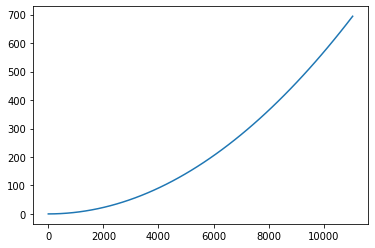

In [100]:
plt.plot(x0, z0)
plt.show()

In [101]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [102]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [103]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    
    sum_0123=0
    length_sum=[]
    for i in range(1,len(z0)):
        sum_0123+=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        length_sum.append(sum_0123)
    
    Ret = Re_t(φ,θ,ψ,length_sum)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ans_x=[]
    ans_y=[]
    ans_z=[]

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(Ws[i]*Ret[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z) 


#     ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_x=[]
    ans_y=[]
    ans_z=[]

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddφ,ddθ,ddψ  = np.array(ans_x),np.array(ans_y),np.array(ans_z) 



#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [104]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [105]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [106]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [107]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [108]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [109]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [110]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [111]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

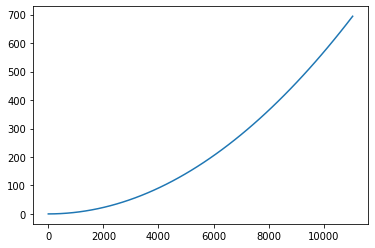

In [112]:
plt.plot(x0_, z0_)
plt.show()

In [113]:
init=1e-12
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.055*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0002*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [114]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [115]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [116]:
vehicle=semisub('DPcontrol',1,0,40.0,0,0) 

In [117]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [118]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

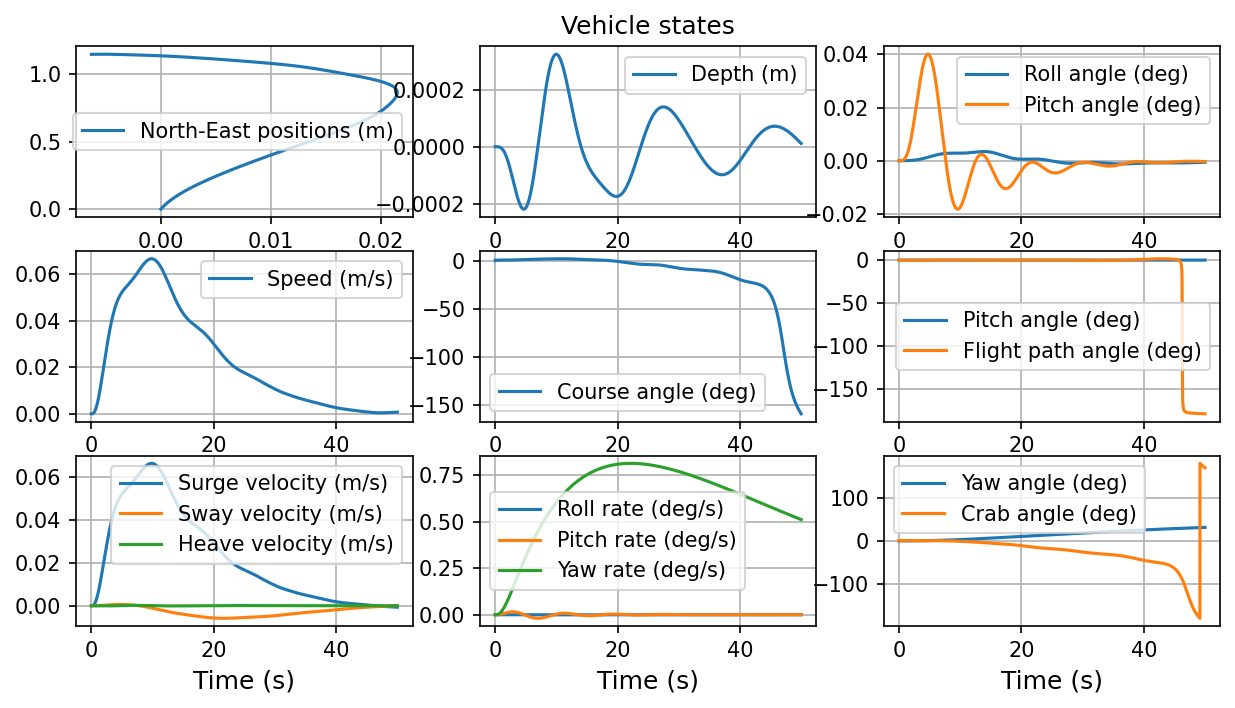

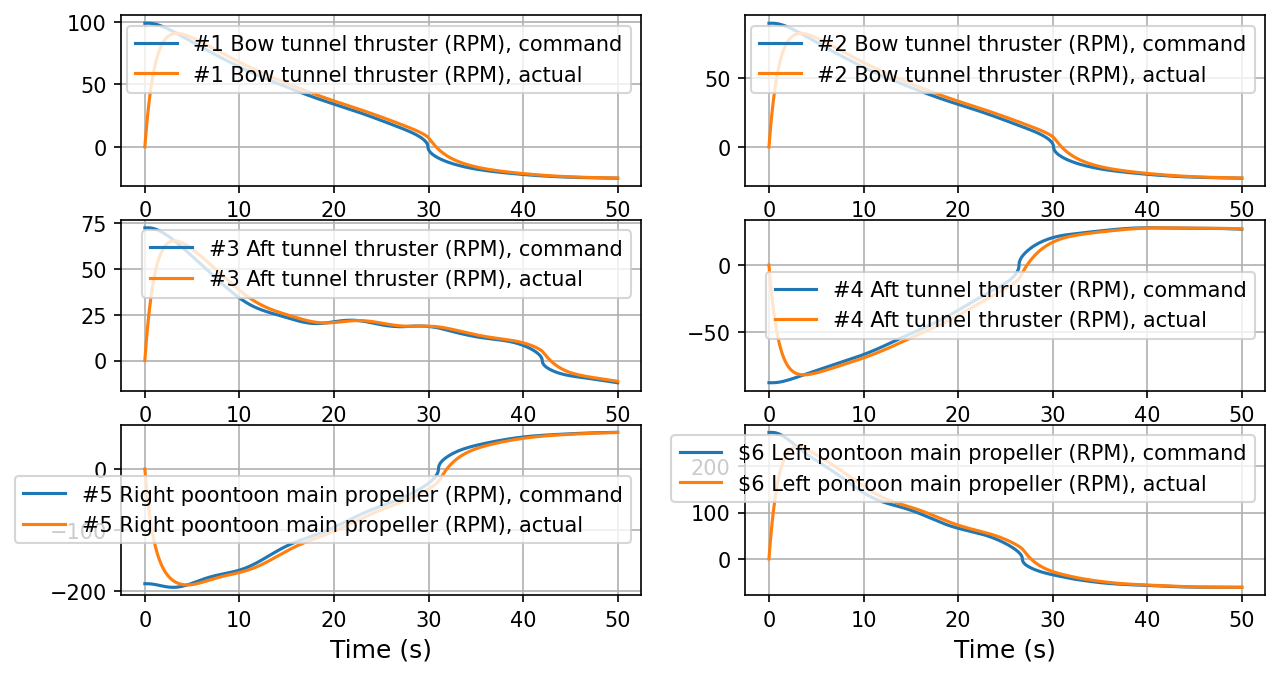

In [119]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [120]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

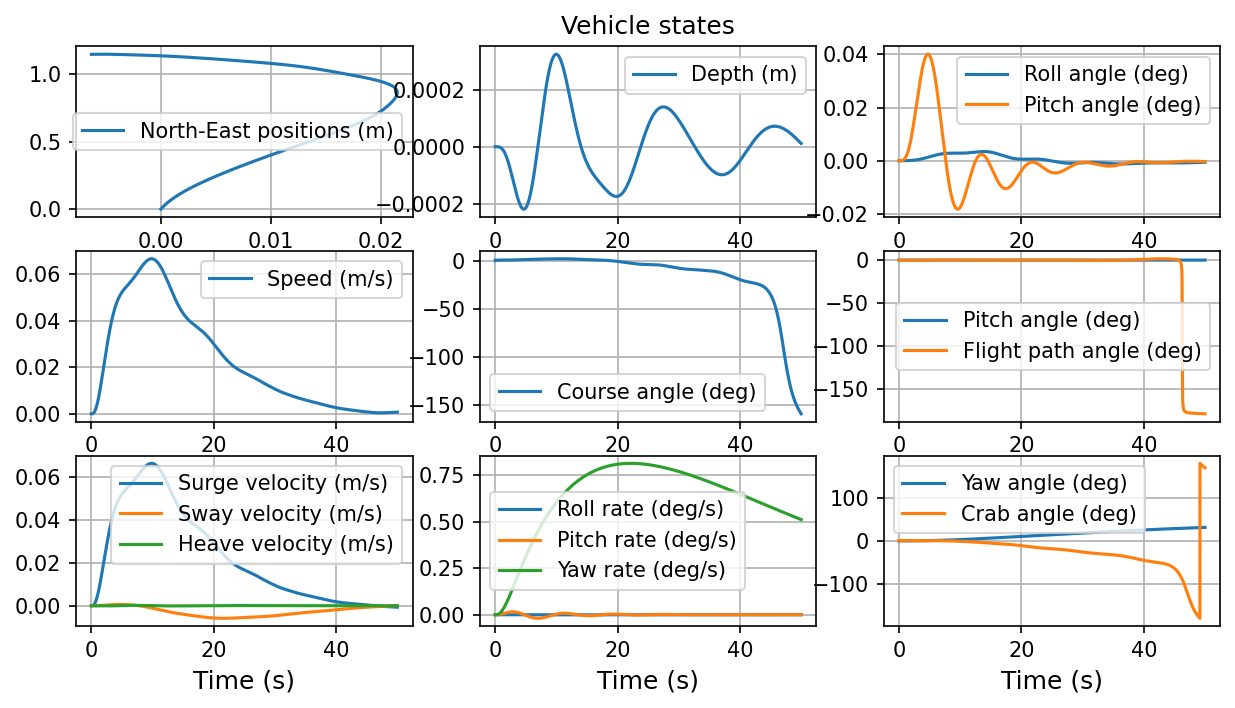

In [121]:
plotVehicleStates(simTime, simData, 3)

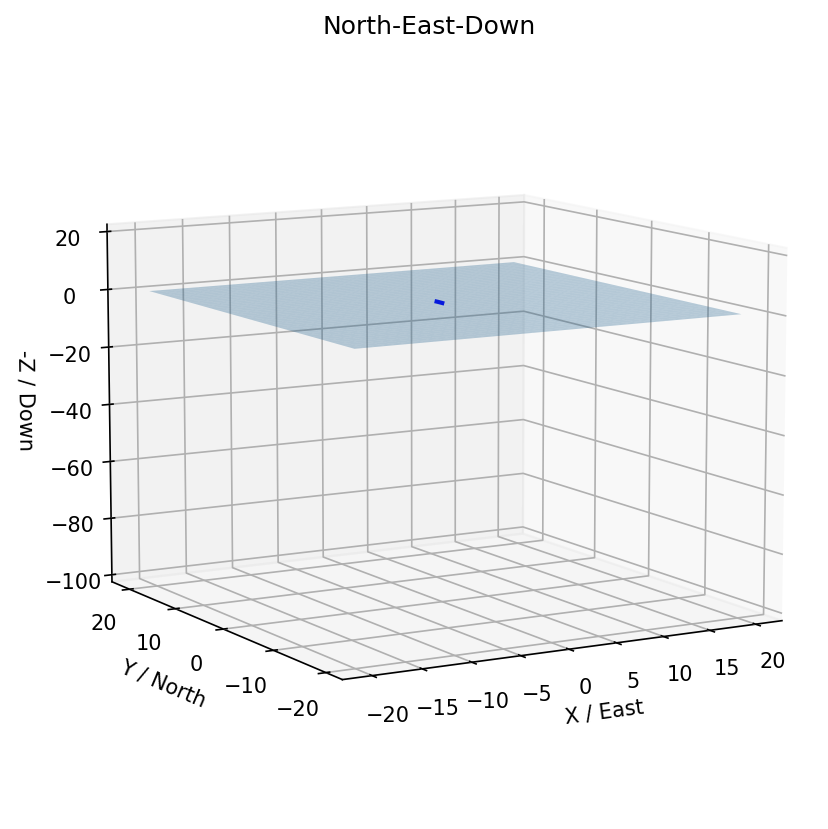

In [122]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [123]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [124]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [183]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    sum_0123=0
    length_sum=[]
    for i in range(1,len(z0)):
        sum_0123+=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        length_sum.append(sum_0123)
    
    Ret = Re_t(φ,θ,ψ,length_sum)
#     Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    
#     Z0=np.dot(Re_b(Ret.astype(np.float64)),tau_force[:3].astype(np.float64)).astype(np.float64)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3], flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################




    ans_x=[]
    ans_y=[]
    ans_z=[]
    
    RRRR=np.einsum('i,ijk->ijk', [Ws[i] for i in range(node_N-1)]
                                             + [Ws[-1] + vessel_mass]
                                             ,Ret)

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z) 

#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

    hack=1e18
#     hack=1
############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
    ans_x=[]
    ans_y=[]
    ans_z=[]

    for i in range(len(Ret)):
        a,b,c=np.linalg.lstsq(hack*A[i],B[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddφ,ddθ,ddψ  = np.array(ans_x),np.array(ans_y),np.array(ans_z) 
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [184]:
# import scipy

In [185]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [186]:
# us=ode15s.integrate(10)

In [187]:
tspan = (0., 0.075)

In [188]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:06.777787


In [189]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 

### Results

In [190]:
fin=us

In [191]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 206
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 6.30413366e-09, 6.93454702e-08, 6.99758836e-07,
       7.00389249e-06, 7.00452291e-05, 5.58379013e-04, 3.15548631e-03,
       1.10127144e-02, 1.81830463e-02, 2.52908061e-02, 3.23985659e-02,
       3.90573546e-02, 4.65264336e-02, 5.27300058e-02, 5.89335780e-02,
       6.37966744e-02, 6.64313776e-02, 6.90660808e-02, 7.05202522e-02,
       7.16422303e-02, 7.25684742e-02, 7.33592713e-02, 7.39430577e-02,
       7.45225320e-02, 7.50000000e-02])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         1.27652619e+03,  2.11006966e+03,  2.93278824e+03],
       [ 4.51129994e+02,  4.51129994e+02,  4.51129994e+02, ...,
         3.02999

In [192]:
t=fin.t

In [193]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


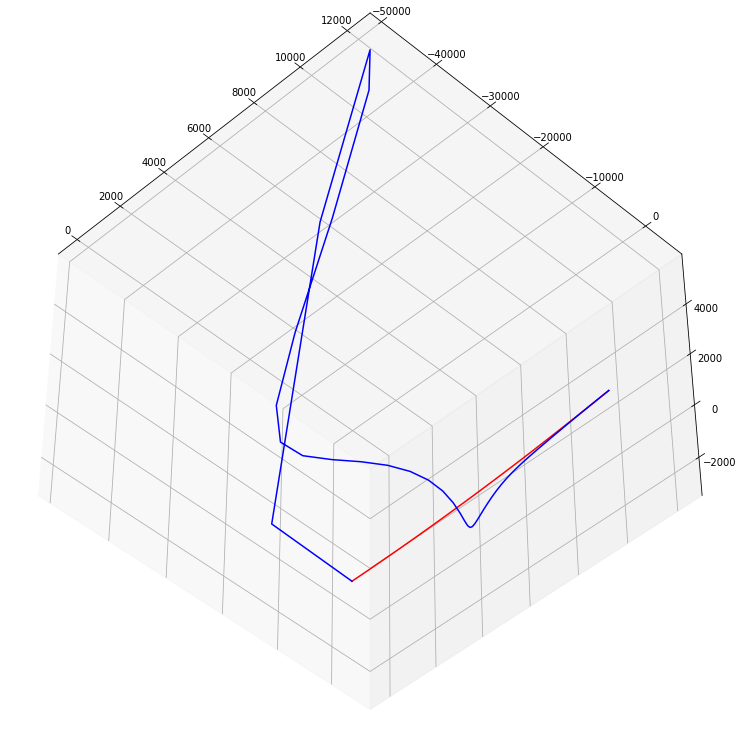

In [194]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [195]:
X,Y,Z

(array([    0.        ,  2932.78824024,  8188.51128636, 12079.25859954,
        11609.58436018,  8367.39047368,  4712.43137152,  1964.42676396,
          547.90563902,   290.56010119,   654.70318026,  1247.94468186,
         1883.07882197,  2474.56710926,  2985.59140966,  3404.94300131,
         3737.35561956,  3999.6158884 ,  4215.77058232,  4408.81156301,
         4595.57200007,  4786.26433995,  4985.4822037 ,  5193.94275632,
         5410.21934048,  5632.0897113 ,  5857.37423532,  6084.34133701,
         6311.81618368,  6539.12182373,  6765.96251072,  6992.29734919,
         7218.22392674,  7443.88629944,  7669.41590649,  7894.90463646,
         8120.40178644,  8345.92411317,  8571.4697    ,  8797.02976653,
         9022.5959545 ,  9248.16318419,  9473.72954847,  9699.29498169,
         9924.85997647, 10150.42489875, 10375.98986136, 10601.55485152,
        10827.11984764, 11052.68486606]),
 array([ 0.00000000e+00, -2.68358049e+04, -4.06614220e+04, -4.82617731e+04,
        -4.6444083

In [196]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [197]:
us=fin.T

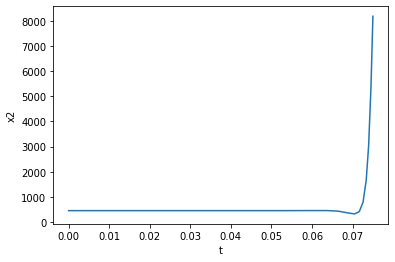

In [198]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

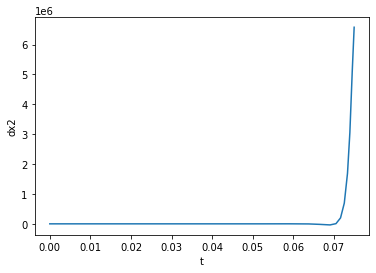

In [199]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

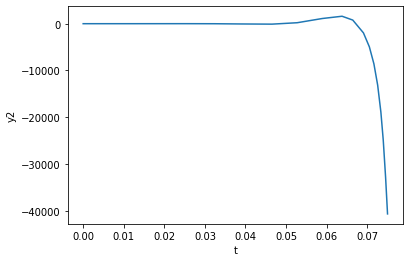

In [200]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

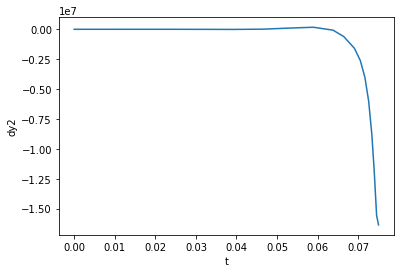

In [201]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

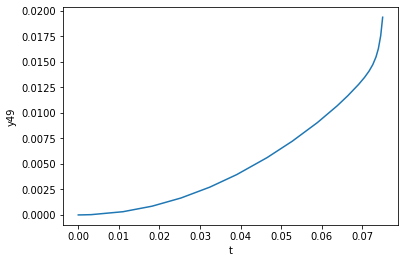

In [202]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

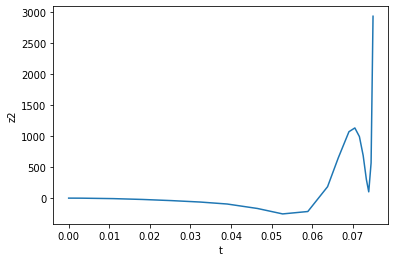

In [203]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

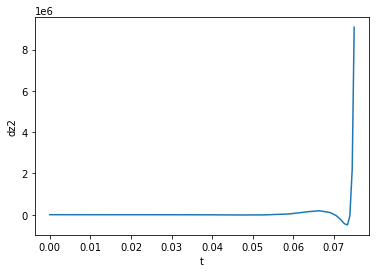

In [204]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

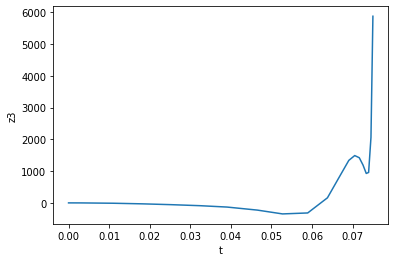

In [205]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

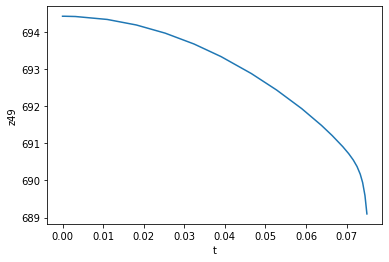

In [206]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

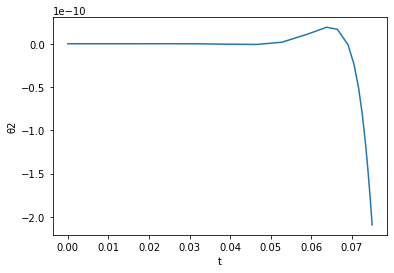

In [207]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

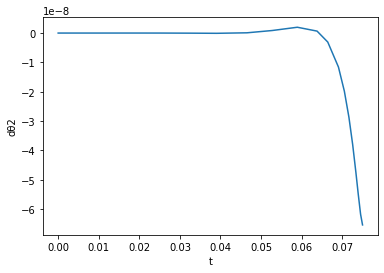

In [208]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

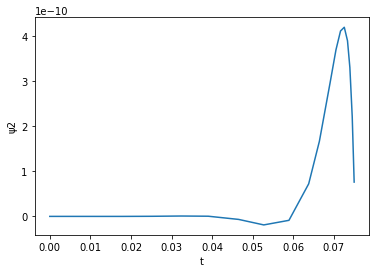

In [209]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

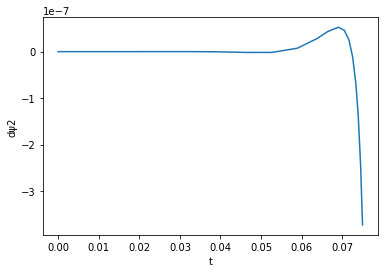

In [210]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()